# Goal

* Create a general supervisor-working agent that can use entrez tools to explore an Entrez record
* Better dealig with large number of Entrez records

# Init

In [24]:
# import 
import os
import time
import json
import xmltodict
from enum import Enum
from pprint import pprint
from typing import Annotated, List, Dict, Tuple, Optional, Union, Any
import xml.etree.ElementTree as ET
from pydantic import BaseModel, Field
from langchain_core.tools import tool
from Bio import Entrez
import pandas as pd
import threading
from dotenv import load_dotenv

In [25]:
# setup
load_dotenv()
pd.set_option('display.max_colwidth', 1000)
os.environ["DEBUG_MODE"] = "TRUE"

In [26]:
# checks
if os.getenv("DEBUG_MODE") == "TRUE":
    print("DEBUG_MODE is enabled.")

DEBUG_MODE is enabled.


In [27]:
# set up Entrez
Entrez.email = "nick.youngblut@arcinstitute.org"
Entrez.api_key = os.getenv("NCBI_API_KEY")
# Set to 10 for API key users
request_limiter = threading.Semaphore(10)

# Tools

In [28]:
def batch_ids(ids, batch_size):
    """
    Batch a list of IDs into smaller lists of a given size.
    """
    for i in range(0, len(ids), batch_size):
        yield ids[i:i + batch_size]

In [35]:
def truncate_values(record, max_length):
    # truncate long values in the record
    root = ET.fromstring(record)
    for item in root.findall(".//Item"):
        if item.text and len(item.text) > max_length:
            item.text = item.text[:max_length] + "...[truncated]"
    # convert back to string
    return ET.tostring(root, encoding="unicode")

In [36]:
@tool 
def esearch(
    esearch_query: Annotated[str, "Entrez query string."],
    database: Annotated[str, "Database name (e.g., sra, gds, or pubmed)"],
    )-> Annotated[List[str], "Entrez IDs of database records"]:
    """
    Run an Entrez search query and return the Entrez IDs of the results.
    Example query for single cell RNA-seq:
        `("single cell"[Title] OR "single-cell"[Title] OR "scRNA-seq"[Title])`
    Example query for an ENA accession number (database = sra):
        `ERX13336121`
    Example query for a GEO accession number (database = gds):
        `GSE51372`
    """
    # debug model
    if os.getenv("DEBUG_MODE") == "TRUE":
        max_records = 2 

    # query
    records = []
    retstart = 0
    retmax = 50
    while True:
        try:
            search_handle = Entrez.esearch(
                db=database, 
                term=esearch_query, 
                retstart=retstart, 
                retmax=retmax
            )
            search_results = Entrez.read(search_handle)
            search_handle.close()
            # delete unneeded keys
            to_rm = ["RetMax", "RetStart"]
            for key in to_rm:
                if key in search_results.keys():
                    del search_results[key]
            # add to records
            records.append(str(search_results))
            # update retstart
            retstart += retmax
            time.sleep(0.33)
            if max_records and len(records) >= max_records:
                break
            if retstart >= int(search_results['Count']):
                break
        except Exception as e:
            print(f"Error searching {database} with query: {esearch_query}: {str(e)}")
            break 
        
    # return records
    if len(records) == 0:
        return(f"No records found for query: {esearch_query}")
    if os.getenv("DEBUG_MODE") == "TRUE":
        records = records[:max_records]  # debug
    return records

# esearch.invoke({"esearch_query" : "GSE51372", "database" : "sra"})
# esearch.invoke({"esearch_query" : "GSE121737", "database" : "gds"})

In [39]:
@tool 
def efetch(
    entrez_ids: Annotated[List[str], "List of Entrez IDs"],
    database: Annotated[str, "Database name (e.g., sra, gds, or pubmed)"],
) -> Annotated[str, "eFetch results in XML format"]:
    """
    Run an Entrez efetch query on Entrez IDs to obtain metadata for the records.
    Useful for obtaining metadata for specific records.
    """
    batch_size = 200  # Maximum number of IDs per request as per NCBI guidelines
    records = []

    for id_batch in batch_ids(entrez_ids, batch_size):
        time.sleep(0.34)  # Respect the rate limit of 3 requests per second
        id_str = ",".join(id_batch)
        try:
            # Fetch the records for the current batch of IDs
            handle = Entrez.efetch(db=database, id=id_str, retmode="xml")
            batch_record = handle.read()
            handle.close()
        except Entrez.Parser.ValidationError:
            print(f"Failed to fetch record for IDs: {id_str}")
            continue  # Skip this batch and proceed to the next
        except Exception as e:
            print(f"An error occurred: {e}")
            continue
        finally:
            try:
                handle.close()
            except:
                pass  # Handle cases where handle might not be open

        # Decode the record if necessary
        if isinstance(batch_record, bytes):
            try:
                batch_record = batch_record.decode("utf-8")
            except Exception as e:
                print(f"Decoding error: {e}")
                continue

        # Truncate long values in the record
        batch_record = truncate_values(batch_record, max_length=1000)

        # convert to XML to JSON
        batch_record = json.dumps(xmltodict.parse(batch_record), indent=2)

        # Check for errors in the response
        if "Error occurred: cannot get document summary" in batch_record:
            print(f"Failed to fetch record for IDs: {id_str}. Try a different database.")
            continue

        records.append(batch_record)

    # Combine all records into a single string
    combined_records = "\n".join(records)

    return combined_records

# records = efetch.invoke({ "entrez_ids" : ["35966237"], "database" : "sra"})
# pprint(records)
# records = efetch.invoke({"entrez_ids" : ["200254051"], "database" : "gds"})
# pprint(records)

In [41]:
@tool
def esummary(
    entrez_ids: Annotated[List[str], "List of Entrez IDs"],
    database: Annotated[str, "Database name (e.g., sra, gds, or pubmed)"],
) -> Annotated[str, "eSummary results in XML format"]:
    """
    Run an Entrez esummary query on Entrez IDs to obtain summary information for the records.
    Useful for obtaining summary information for specific records.
    """
    batch_size = 200  # Maximum number of IDs per request as per NCBI guidelines
    max_string_length = 500  # Maximum length of a string in the record
    records = []
    
    for id_batch in batch_ids(entrez_ids, batch_size):
        time.sleep(0.34)  # Respect NCBI's rate limits (no more than 3 requests per second)
        id_str = ",".join(id_batch)
        
        try:
            # Fetch summary record for the current batch
            handle = Entrez.esummary(db=database, id=id_str, retmode="xml")
            batch_record = handle.read()
            handle.close()
        except Entrez.Parser.ValidationError:
            print(f"Failed to fetch summary for IDs: {id_str}. Check if the IDs exist.")
            continue 
        except Exception as e:
            print(f"An error occurred: {e}")
            continue
        finally:
            try:
                handle.close()
            except:
                pass  # Handle cases where the handle might not be open
        
        # Decode the record if necessary
        if isinstance(batch_record, bytes):
            try:
                batch_record = batch_record.decode("utf-8")
            except Exception as e:
                print(f"Decoding error: {e}")
                continue
            
        # Truncate long values in the record
        batch_record = truncate_values(batch_record, max_length=500)

        # convert to XML to JSON
        batch_record = json.dumps(xmltodict.parse(batch_record), indent=2)

        # Check for errors in the response
        if "ERROR" in batch_record.upper() or "INVALID_ID" in batch_record.upper():
            print(f"Failed to fetch summary for IDs: {id_str}. Try a different database or verify the IDs.")
            continue

        # Append the batch record to the list of records
        records.append(batch_record)
    
    # Combine all batch records into a single string
    combined_records = "\n".join(records)
    return combined_records

# esummary.invoke({"entrez_ids" : ["35966237"], "database" : "sra"})
# esummary.invoke({"entrez_ids" : ["200121737"], "database" : "sra"})
# esummary.invoke({"entrez_ids" : ["6697288"], "database" : "sra"})
# IDs = ["200148729", "100024676", "100020301", "100018573", "305022831", "305022830", "305022829", "305022828", "305022827", "305022826"]
# esummary.invoke({"entrez_ids" : IDs, "database" : "gds"})

In [43]:
@tool
def elink(
    entrez_ids: Annotated[List[str], "List of Entrez IDs"],
    source_db: Annotated[str, "Source database (e.g., 'sra')"],
    target_db: Annotated[str, "Target database (e.g., 'bioproject', 'biosample', 'pubmed')"],
) -> Annotated[str, "eLink results in XML format"]:
    """
    Find related entries between Entrez databases, particularly useful for finding
    BioProject, BioSample, or publication records related to SRA entries.
    """
    batch_size = 200  # Maximum number of IDs per request as per NCBI guidelines
    records = []

    for id_batch in batch_ids(entrez_ids, batch_size):
        time.sleep(0.34)  # Respect NCBI's rate limits (no more than 3 requests per second)
        id_str = ",".join(id_batch)
        
        try:
            handle = Entrez.elink(
                id=id_str,
                dbfrom=source_db,
                db=target_db,
                retmode="xml"
            )
            batch_record = handle.read()
            handle.close()
        except Entrez.Parser.ValidationError:
            print(f"Failed to find links for IDs: {id_str}")
            continue  # Skip this batch and proceed to the next
        except Exception as e:
            print(f"An error occurred: {e}")
            continue
        finally:
            try:
                handle.close()
            except:
                pass  # Handle cases where the handle might not be open
        
        # Decode the record if necessary
        if isinstance(batch_record, bytes):
            try:
                batch_record = batch_record.decode("utf-8")
            except Exception as e:
                print(f"Decoding error: {e}")
                continue

        # Truncate long values in the record
        batch_record = truncate_values(batch_record, max_length=1000)

        # convert to XML to JSON
        batch_record = json.dumps(xmltodict.parse(batch_record), indent=2)

        # Check for errors in the response
        if "ERROR" in batch_record.upper():
            print(f"Failed to find links for IDs: {id_str}. Verify database names ({source_db}, {target_db}) and Entrez IDs.")
            continue

        # Append the batch record to the list of records
        records.append(batch_record)
    
    # Combine all batch records into a single string
    return "\n".join(records)

# elink.invoke({"entrez_ids" : ["35966237", "200254051"], "source_db" : "gds", "target_db" : "pubmed"})
# elink.invoke({"entrez_ids" : ['200121737', '100024679', '303444964', '303444963', '303444962'], "source_db" : "gds", "target_db" : "sra"})
# elink.invoke({"entrez_ids" : ["200148729"], "source_db" : "gds", "target_db" : "sra"})

In [44]:
@tool
def which_entrez_databases(
    entrez_ids: Annotated[List[str], "List of Entrez IDs"],
) -> Annotated[str, "List of databases where each Entrez ID is found."]:
    """
    Check which databases an Entrez ID is found in.
    """
    databases = ["sra", "gds", "pubmed", "biosample", "bioproject"]
    found_in = {entrez_id: [] for entrez_id in entrez_ids}

    for db in databases:
        for id_batch in batch_ids(entrez_ids, 200):
            time.sleep(0.34)  # Respect the rate limit
            try:
                handle = Entrez.esummary(db=db, id=",".join(id_batch))
                records = Entrez.read(handle)
                handle.close()
                # Extract the IDs that were successfully retrieved
                if isinstance(records, list):
                    found_ids = {record['Id'] for record in records}
                else:
                    # In case only one record is returned
                    found_ids = {records['Id']}
                for entrez_id in found_ids:
                    found_in[entrez_id].append(db)
            except Exception as e:
                continue

    # Prepare the output
    output_lines = []
    for entrez_id in entrez_ids:
        if not found_in[entrez_id]:
            output_lines.append(f"Entrez ID {entrez_id} not found in any databases.")
        else:
            output_lines.append(f"Entrez ID {entrez_id} found in: {', '.join(found_in[entrez_id])}.")

    return "\n".join(output_lines)

# Example usage
# which_entrez_databases.invoke({"entrez_ids" : ['200121737', '100024679', '303444964']})

# Models

In [45]:
from langchain_openai import ChatOpenAI

In [46]:
# set model
model_supervisor = ChatOpenAI(model="gpt-4o", temperature=0.1)
model_worker = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Agents

In [47]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

## esearch

In [48]:
esearch_agent = create_react_agent(
    model=model_worker,
    tools=[esearch],
    state_modifier="\n".join([
        "You are an expert in bioinformatics and you are working on a project to find information about a specific dataset.",
        "Based on the task provided by your supervisor, use Entrez esearch to help complete the task.",
        "Provide a concise summary of your findings; use lists when possible; do not include helpful wording.",
    ])
)

# inputs = {"messages": [("user", "Investigate GSE121737")]}
# esearch_agent.invoke(inputs)

In [49]:
@tool
def invoke_esearch_worker(
    message: Annotated[str, "Message to the worker"],
) -> Annotated[str, "Response from the worker"]:
    """
    Invoke the esearch worker to perform a task.
    """
    result = esearch_agent.invoke({"messages": [("user", message)]})
    # just return the response
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name="esearch worker")]
    }

#invoke_esearch_worker.invoke({"message" : "Investigate GSE121737"})

## esummary

In [50]:
esummary_agent = create_react_agent(
    model=model_worker,
    tools=[esummary, which_entrez_databases],
    state_modifier="\n".join([
        "You are an expert in bioinformatics and you are working on a project to find information about a specific dataset.",
        "Based on the task provided by your supervisor, use Entrez esummary to help complete the task.",
        "You can use which_entrez_databases to determine which databases to use for esummary queries.",
        "Provide a concise summary of your findings; use lists when possible; do not include helpful wording.",
    ])
)

In [51]:
@tool
def invoke_esummary_worker(
    message: Annotated[str, "Message to the worker. Be sure to provide Entrez IDs."],
) -> Annotated[str, "Response from the worker"]:
    """
    Invoke the esummary worker to perform a task.
    """
    result = esummary_agent.invoke({"messages": [("user", message)]})
    # just return the final response
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name="esummary worker")]
    }

# invoke_esummary_worker.invoke({"message" : "Investigate Entrez ID 35966237"})

## efetch

In [52]:
efetch_agent = create_react_agent(
    model=model_worker,
    tools=[efetch, which_entrez_databases],
    state_modifier="\n".join([
        "You are an expert in bioinformatics and you are working on a project to find information about a specific dataset.",
        "Based on the task provided by your supervisor, use Entrez efetch to help complete the task.",
        "You can use which_entrez_databases to determine which databases to use for efetch queries.",
        "Provide a concise summary of your findings; use lists when possible; do not include helpful wording.",
    ])
)

In [53]:
@tool
def invoke_efetch_worker(
    message: Annotated[str, "Message to the worker. Be sure to provide Entrez IDs."],
) -> Annotated[str, "Response from the worker"]:
    """
    Invoke the efetch worker to perform a task.
    """
    result = efetch_agent.invoke({"messages": [("user", message)]})
    # just return the final response
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name="efetch worker")]
    }

## elink

In [54]:
elink_agent = create_react_agent(
    model=model_supervisor,
    tools=[elink, which_entrez_databases],
    state_modifier="\n".join([
        "You are an expert in bioinformatics and you are working on a project to find information about a specific dataset.",
        "Based on the task provided by your supervisor, use Entrez elink to help complete the task.",
        "elink is useful for finding related entries between Entrez databases.",
        "Generally, you will want to use the which_entrez_databases tool to determine which databases to use for elink queries.",
        "Note that elink results are composed of Entrez IDs and not accessions (e.g., SRA accessions).",
        "Provide a concise summary of your findings; use lists when possible; do not include helpful wording.",
    ])
)

In [55]:
@tool
def invoke_elink_worker(
    message: Annotated[str, "Message to the worker. Be sure to provide Entrez IDs."],
) -> Annotated[str, "Response from the worker"]:
    """
    Invoke the efetch worker to perform a task.
    """
    result = elink_agent.invoke({"messages": [("user", message)]})
    # just return the final response
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name="elink worker")]
    }

## Supervisor

In [56]:
entrez_agent = create_react_agent(
    model=model_supervisor,
    tools=[invoke_esearch_worker, invoke_esummary_worker, invoke_efetch_worker, invoke_elink_worker, which_entrez_databases],
    state_modifier="\n".join([
        "You are a helpful senior bioinformatician assisting a researcher with a task involving Entrez databases.",
        "You have a team of workers who can perform specific tasks using Entrez tools.",
        "Provide guidance to the workers to help them complete the task successfully.",
        "Generally, start with eSearch to find Entrez records, then use eFetch to get detailed information.",
        "Use eSummary to obtain summary information on an Entrez record.",
        "Use eLink to navigate between databases to find related records (e.g., GEO to SRA).",
        "Generally, you will want to specify the database(s) to search (e.g., sra, gds, or pubmed).",
        "If there are dozens of records, batch the IDs and call the worker multiple times to avoid rate limits and token count limits.",
        "Continue sending tasks to your workers until you successfully complete the task.",
        "Be very concise; provide simple lists when possible; do not include unnecessary wording such as \"If you need further assistance\".",
        "\n#-- Accession notes --#",
        "SRA accesssion prefixes: SRX, SRP, SRR",
        "ENA accession prefixes: ERX, PRJNA, DRX, E-MTAB",
        "GEO accession prefixes: GSE, GSM, GPL",
        "BioProject accession prefixes: PRJNA, PRJEB, PRJDB",
        "BioSample accession prefixes: SAMN, SAME",
        "#-- Database notes --#",
        "Entrez databases: sra, gds, pubmed, biosample, bioproject",
        "#-- Example workflows --#",
        "# Task: Convert GSE123456 to SRX, SRP, or SRR accessions",
        "  1. esearch of GSE accession to obtain Entrez IDs",
        "  2. esummary of the Entrez IDs to get the SRX accessions"
    ])
)

# invoke the agent
inputs = {"messages": [("user", "Convert GSE121737 to SRX accessions")]}
config = {"max_concurrency" : 8, "recursion_limit": 50}
#for step in entrez_agent.stream(inputs, config=config):
#    print(step)


In [57]:
inputs = {"messages": [("user", "Obtain any available SRP accessions for GSE148729")]}
config = {"max_concurrency" : 8, "recursion_limit": 50}
for step in entrez_agent.stream(inputs, config=config):
    print(step)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ghmMyycxfAEJEvqAtzdpYFIy', 'function': {'arguments': '{"message":"Search for GSE148729 in the gds database to obtain Entrez IDs."}', 'name': 'invoke_esearch_worker'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 585, 'total_tokens': 617, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8f2b4885-db90-46a7-bd29-4bc3aa97d99a-0', tool_calls=[{'name': 'invoke_esearch_worker', 'args': {'message': 'Search for GSE148729 in the gds database to obtain Entrez IDs.'}, 'id': 'call_ghmMyycxfAEJEvqAtzdpYFIy', 'type': 'tool_call'}], usage_metadata={'input_

In [58]:
inputs = {"messages": [("user", "Obtain any available publications for GSE196830")]}
config = {"max_concurrency" : 8, "recursion_limit": 50}
for step in entrez_agent.stream(inputs, config=config):
    print(step)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1SkjdJe56vNX5604sq1zQWAz', 'function': {'arguments': '{"message":"Search for GSE196830 in the gds database to obtain Entrez IDs."}', 'name': 'invoke_esearch_worker'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 582, 'total_tokens': 614, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-312dcbd1-5c17-490a-8d15-02679b601f65-0', tool_calls=[{'name': 'invoke_esearch_worker', 'args': {'message': 'Search for GSE196830 in the gds database to obtain Entrez IDs.'}, 'id': 'call_1SkjdJe56vNX5604sq1zQWAz', 'type': 'tool_call'}], usage_metadata={'input_

***

# Graph

In [1]:
import operator
from typing import Annotated, Sequence, Tuple, Union, Required
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.types import Send
from langgraph.graph import START, END, StateGraph, MessagesState
from pydantic import BaseModel, Field
from langgraph.prebuilt import create_react_agent, ToolNode

In [2]:
# set model
model_big = ChatOpenAI(model="gpt-4o")
model = ChatOpenAI(model="gpt-4o-mini")

In [3]:
def worker_agent_node(state, agent, name):
    """
    Convert agent output to a human message for the graph.
    Just returns the last message from the agent.
    Args:
        state: The current state of the graph.
        agent: The agent that generated the messages.
        name: The name of the agent.
    """
    # just last command to worker agent
    result = agent.invoke(state["messages"][-1])
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

In [ ]:
entrez_agent = create_react_agent(
    model=model_big,
    tools=[esearch, efetch, esummary, elink],
    state_modifier="\n".join([
        "You are provided with an Entrez record ID.",
        "Your task is to gather information about the dataset associated with the record.",
        "Start with the eSearch tool to find the record, then use eFetch to get detailed information.",
        "Use eSummary to obtain summary information of the record.",
        "Your primary goal is to obtain SRA accessions (e.g., SRX, SRP, SRR) associated with the Entrez record.",
        "If you obtain non-SRA accessions (e.g., ERX, PRJNA, DRX, E-MTAB), use eLink to find related SRA records.",
        "Use eLink to navigate between databases and map non-SRA accessions to SRA accessions.",
        "Continue using eLink and other tools until you successfully obtain the SRA accession numbers.",
        "Verify each accession to ensure it is an SRA accession; if not, keep searching.",
        "Summarize the SRA accessions you have found at the end of your search.",
        "#-- Accession notes --#",
        "SRA accesssion prefixes: SRX, SRP, SRR",
        "ENA accession prefixes: ERX, PRJNA, DRX, E-MTAB",
        "#-- elink notes --#",
        "ENA to SRA: elink(source_db='sra', target_db='end'",
    ])
)

In [98]:
# subclass the state
class GraphState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    SRX: Annotated[List[str], "SRX accessions associated with the dataset."]
    SRP: Annotated[List[str], "SRP accessions associated with the dataset."]
    SRR: Annotated[List[str], "SRR accessions associated with the dataset."]

In [99]:
# node to generate a structured output of accessions
class Accesions(TypedDict):
    SRX: List[str]
    SRP: List[str]
    SRR: List[str]

def get_accessions(state: GraphState) -> Accesions:
    """
    Extract the SRA experiment accessions (SRX) from the state.
    """
     # Create a prompt template that includes previous messages
    prompt = ChatPromptTemplate.from_messages([
        # First add any static system message if needed
        ("system", "You are an expert in bioinformatics and have been asked to analyze an SRA dataset."),
        # Include all previous messages from the state
        MessagesPlaceholder(variable_name="history"),
        # Add the final question/instruction
        ("human", "\n".join([
            "Based on the information above, determine the following:",
            "1. The SRX accessions associated with the dataset.",
            "2. The SRP accessions associated with the dataset.",
            "3. The SRR accessions associated with the dataset."
            "If you cannot find any particular type of accession, you can leave it blank."
            ])
        ),
    ])
    # Format the prompt with the message history
    formatted_prompt = prompt.format_messages(
        history=state["messages"]
    )
    # Use the formatted prompt with the LLM
    return model.with_structured_output(Accesions, strict=True).invoke(formatted_prompt)

# test get_accessions
# state = {
#     "messages": [HumanMessage(content="The accession is SRR13112659. The dataset is from a single-cell RNA-seq experiment with Illumina paired-end reads. There is another accession: SRP319646. The dataset is from a study on the human brain. The dataset is part of a larger project with the accession PR")],
# }
#get_accessions(state)

In [100]:
#-- graph --#
workflow = StateGraph(GraphState)

# nodes
workflow.add_node("entrez_agent_node", entrez_agent)
workflow.add_node("get_accessions_node", get_accessions)

# edges
workflow.add_edge(START, "entrez_agent_node")
#workflow.add_edge("entrez_agent_node", END)
workflow.add_edge("entrez_agent_node", "get_accessions_node")
workflow.add_edge("get_accessions_node", END)

# compile the graph
graph = workflow.compile()

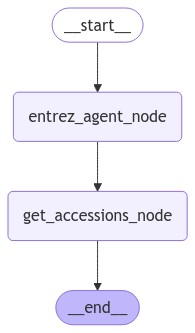

In [101]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [102]:
# Call the graph and stream
#input = {"entrez_id" : "35966237", "database" : "sra"}
#input = {"messages" : [HumanMessage(content="Entrez ID: 35966237")]}
input = {"messages" : [HumanMessage(content="Entrez ID: 36029097")]}
for step in graph.stream(input, config={"max_concurrency" : 3, "recursion_limit": 30}):
    print(step)
    final_step = step

{'entrez_agent_node': {'messages': [HumanMessage(content='Entrez ID: 36029097', additional_kwargs={}, response_metadata={}, id='1b7b9def-2a57-462b-8e05-fc57c75ad568'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LT2gZ25PDPYCLCQDegj34Lbt', 'function': {'arguments': '{"database":"sra","entrez_id":"36029097"}', 'name': 'esummary'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 484, 'total_tokens': 507, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d8aab24f-7a65-44ac-aedb-25ab7e509f93-0', tool_calls=[{'name': 'esummary', 'args': {'database': 'sra', 'entrez_id': '36029097'}, 'id': 'call_LT2gZ25PDPYCLCQDegj34Lb

In [103]:
final_step

{'get_accessions_node': {'SRX': [], 'SRP': [], 'SRR': ['ERR13934239']}}